In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy


In [3]:

# for run_file in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all_0-ft/reports/residuals/best_resids/63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_best_resids_R2_0.2127_all.csv'):
for run_file in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all-10x-h_*/reports/residuals/best_resids/*_all.csv'):
# for run_file in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all-10x-h_*/reports/residuals/best_resids/*_ho.csv'):


    hof = run_file.replace('_all.csv', '_ho.csv')
    ho_inx = pd.read_csv(hof)['Unnamed: 0']

    resid_df = pd.read_csv(run_file)
    resid_df['is_holdout'] = resid_df['Unnamed: 0'].isin(ho_inx)
    assert resid_df['is_holdout'].sum() == len(ho_inx)

    resid_df = resid_df[~resid_df['dupe']]

    # display(resid_df)
    # break

    b0 = np.arange(len(resid_df))
    # display(b0)

    rdc = []

    lb = -40
    ub = 100

    pred_params_cols = [_ for _ in resid_df.columns if 'pred_paramsNum=' in _]
    print(pred_params_cols)

    if len([_ for _ in resid_df.columns if 'run_num=9' in _]) < 1:
        continue

    true_col = pred_params_cols[0].replace('pred_paramsNum=0_', '').split('_')[0]
    print('true_col', true_col)

    for event_col in ['photometrySideInIndexr']:
        resid_df_cutdown = resid_df[['Unnamed: 0', 'file_num', 'dupe', 'nTrial', 'nEndTrial', 'wi_trial_keep',
                                    'gDA', 'gACH', 'rDA', event_col] + pred_params_cols].copy()

        event = np.where(resid_df_cutdown[event_col].values == 1)[0]
        print(b0.shape, event.shape)
        for iev, ev in enumerate(event):
            delta = b0 - ev
            # print(delta)
            keep_eg = (delta >= -40)&(delta <= 100)&(resid_df['is_holdout'])
            delta_keep_eg = delta[keep_eg]
            rdf_tmp = resid_df_cutdown.loc[keep_eg].copy()
            rdf_tmp['delta'] = delta_keep_eg
            # rdf_tmp = rdf_tmp[~rdf_tmp['dupe']]
            # display(rdf_tmp)
            # display(list(rdf_tmp.columns))
            rdc.append(rdf_tmp.set_index('delta'))

        # rdc_df = pd.concat(rdc, axis=0)
        # display(rdc_df)
        # rdc_df = rdc_df[[true_col]]
        # delta_index.append(delta)
        # delta_val.append((bs.confidence_interval.low, mn_val, bs.confidence_interval.high))

        reconstruction_data_list = []

        seed = np.random.randint(1000000000)
        for bootstrap_col in [true_col] + pred_params_cols:
            rdc_lst = []
            for rdc_df in rdc:
                rdc_lst.append(rdc_df[[bootstrap_col]])
            rdc_df = pd.concat(rdc_lst, axis=1)

            for delta in rdc_df.index:
                row = rdc_df.loc[delta].dropna().values
                mn_val = row.mean()
                bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
                                           batch=None, vectorized=True, paired=False,
                                           axis=0, confidence_level=0.95, method='BCa',
                                           random_state=seed)
                
                rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)
                reconstruction_data_list.append(rtup)
                print(reconstruction_data_list[-1])

                
        
        break
    # break

        # tmp_lst = [_.set_index('delta')[['gDA']] for _ in rdc]
        # tmp_cat = []
        # for itmp, tmp in enumerate(tmp_lst):
        #     tmp_cat.append(tmp)
        #     if itmp > 100000:
        #         break

        # tmp_df = pd.concat(tmp_cat, axis=1)


In [37]:
# for tmp_rf in sorted(glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all-10x-h_*/reports/residuals/best_resids/*_all.csv')):
#     cols = list(pd.read_csv(tmp_rf, nrows=10).columns)
#     if len([_ for _ in cols if 'pred_paramsNum' in _]) != 90:
#         continue
#     print(tmp_rf, [_ for _ in cols if 'pred_paramsNum' in _])

In [49]:
coefs = pd.DataFrame(reconstruction_data_list, columns=['col', 'delta', 'lb', 'mn', 'ub']).sort_values(['col', 'delta'])

In [50]:
coefs['resp'] = coefs['col'].str.split('_run_').apply(lambda x: x[0].replace('pred_paramsNum=', '').split('_')[-1])
coefs['param_num'] = coefs['col'].str.split('_run_').apply(lambda x: x[0].replace('pred_paramsNum=', ''))
coefs['rnum'] = coefs['col'].str.split('_run_').apply(lambda x: x[-1])
coefs

,col,delta,lb,mn,ub,resp,param_num,rnum
0,gDA,-40,-0.186059,-0.134212,-0.085690,gDA,gDA,gDA
1,gDA,-39,-0.159347,-0.109808,-0.059164,gDA,gDA,gDA
2,gDA,-38,-0.164429,-0.112990,-0.060746,gDA,gDA,gDA
3,gDA,-37,-0.184043,-0.131867,-0.080578,gDA,gDA,gDA
4,gDA,-36,-0.218059,-0.165751,-0.114667,gDA,gDA,gDA
...,...,...,...,...,...,...,...,...
7627,pred_paramsNum=8_gDA_run_num=5,-27,-0.137920,-0.131259,-0.124663,gDA,8_gDA,num=5
7628,pred_paramsNum=8_gDA_run_num=5,-26,-0.139405,-0.133099,-0.126628,gDA,8_gDA,num=5
7629,pred_paramsNum=8_gDA_run_num=5,-25,-0.142005,-0.135563,-0.129005,gDA,8_gDA,num=5
7630,pred_paramsNum=8_gDA_run_num=5,-24,-0.148078,-0.141045,-0.133967,gDA,8_gDA,num=5


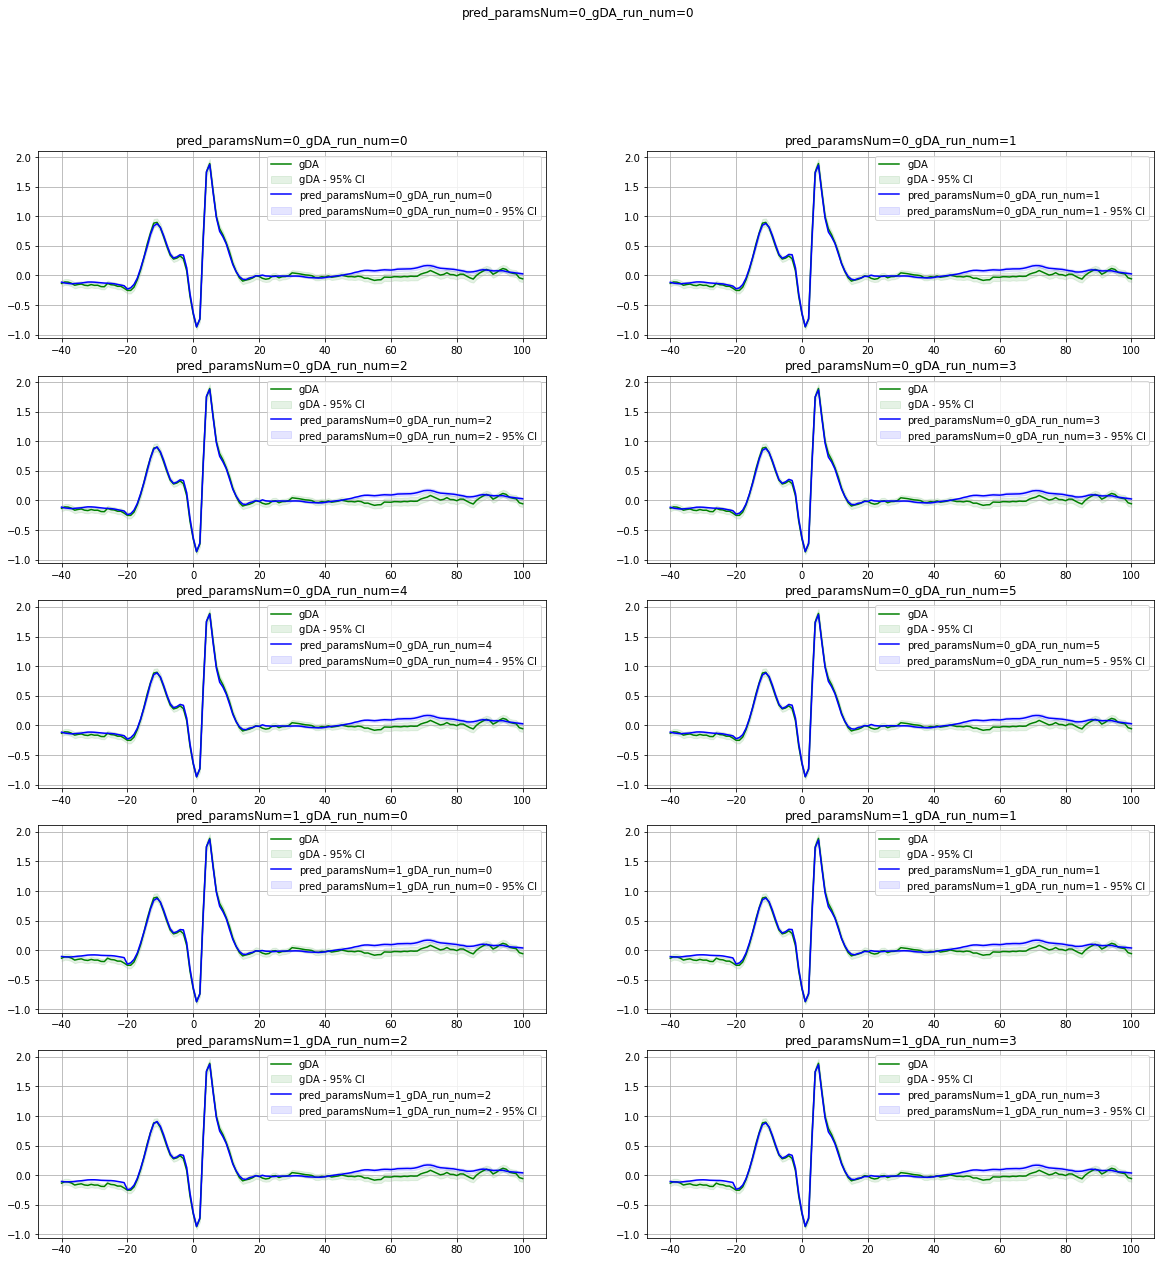

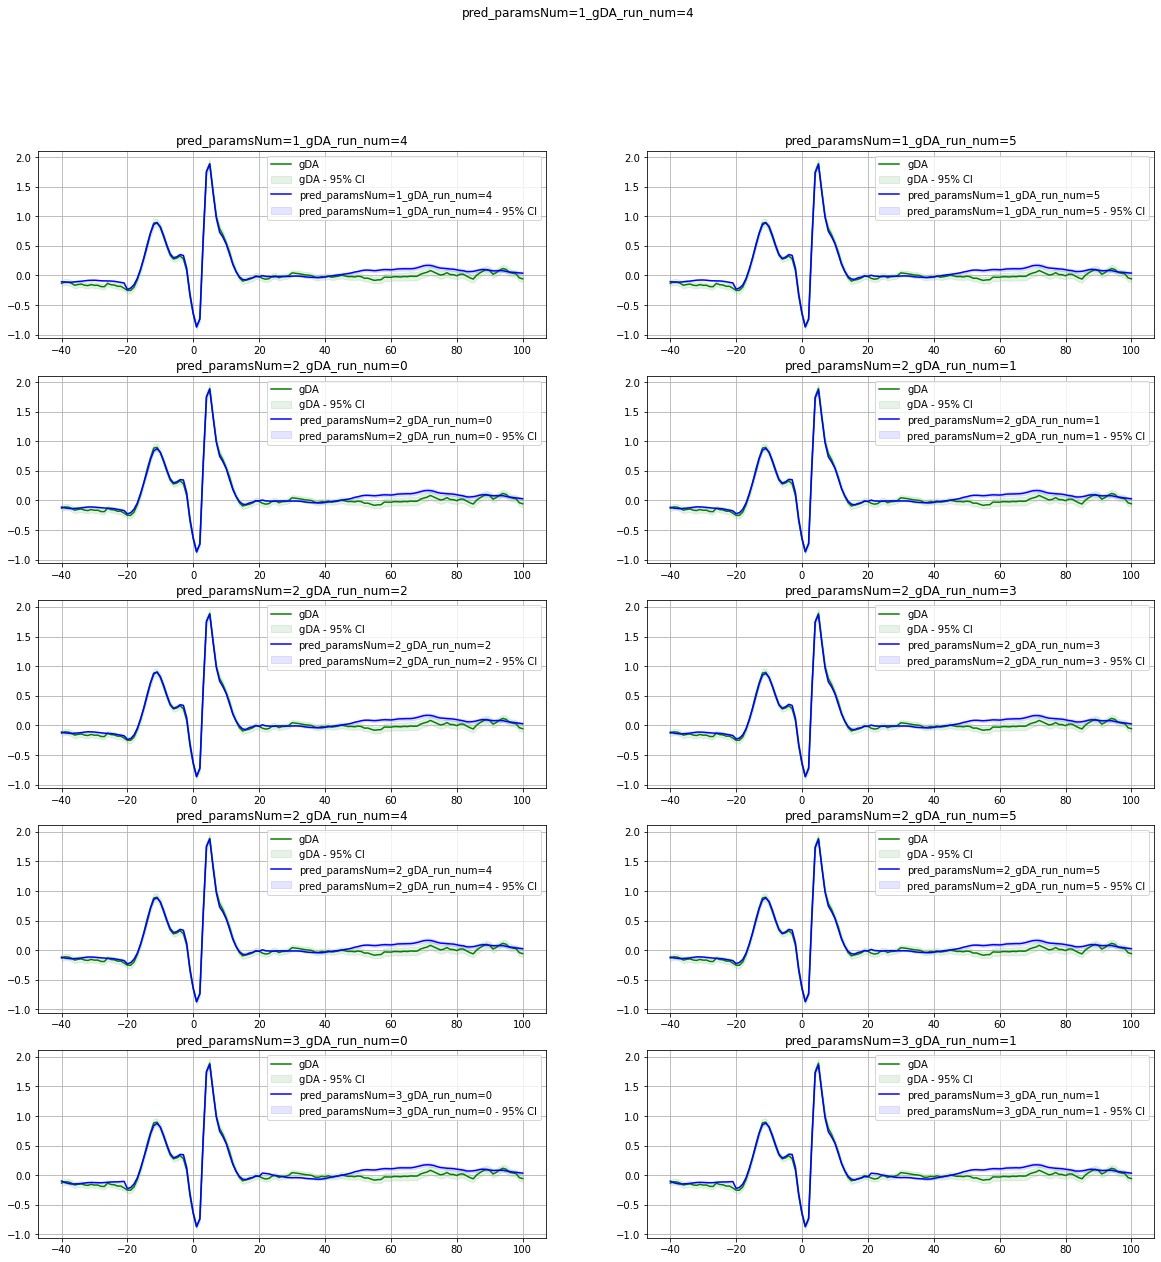

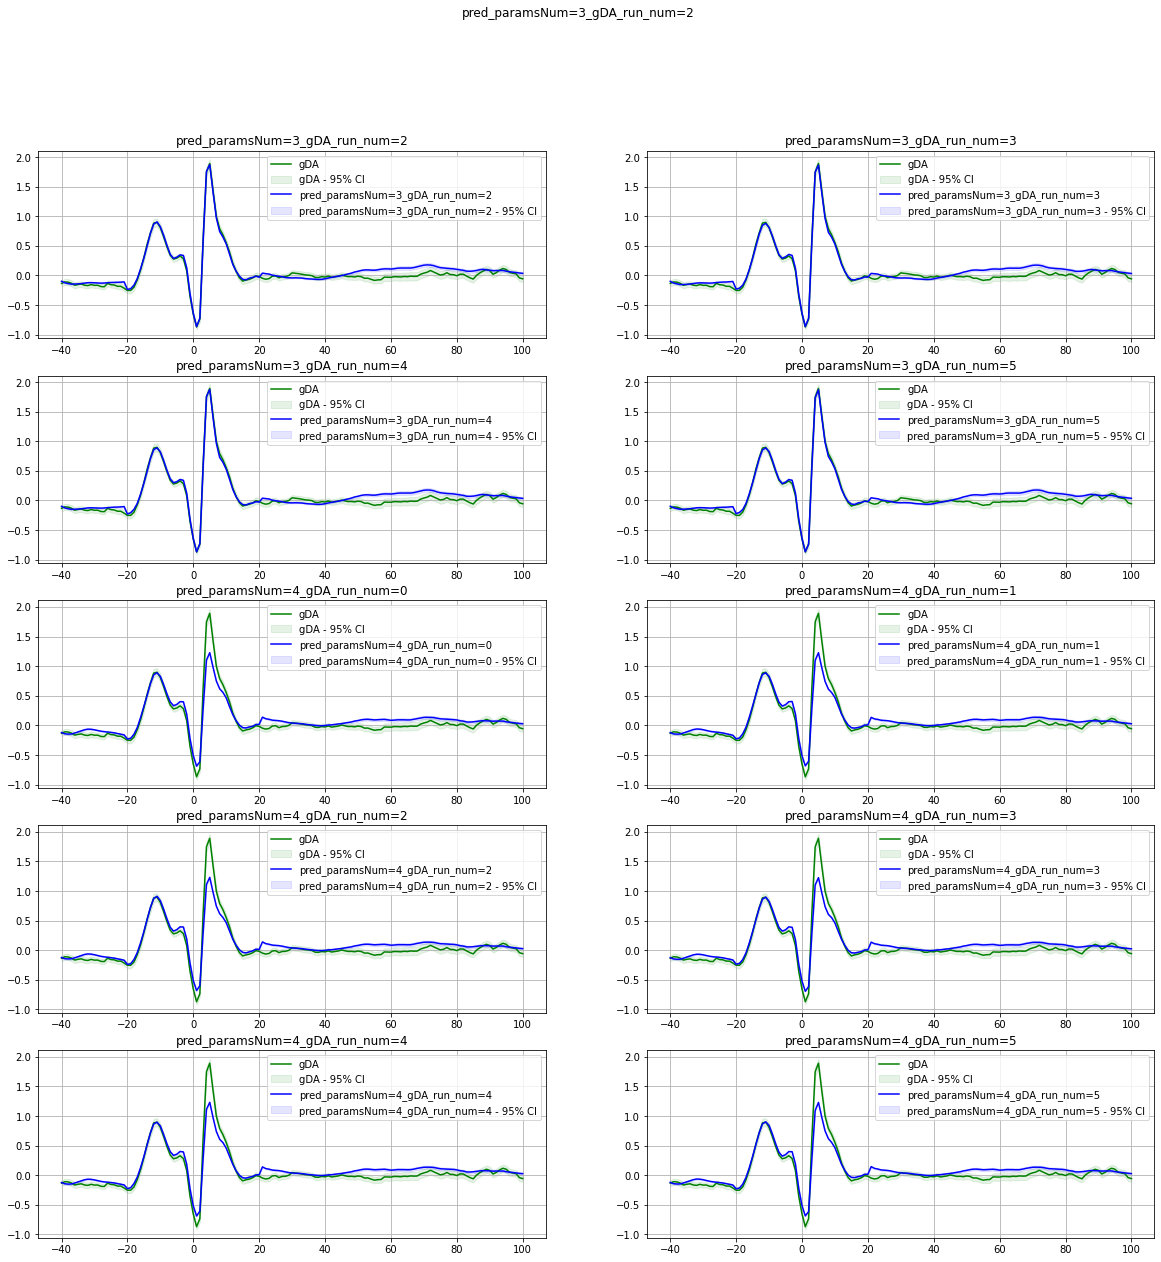

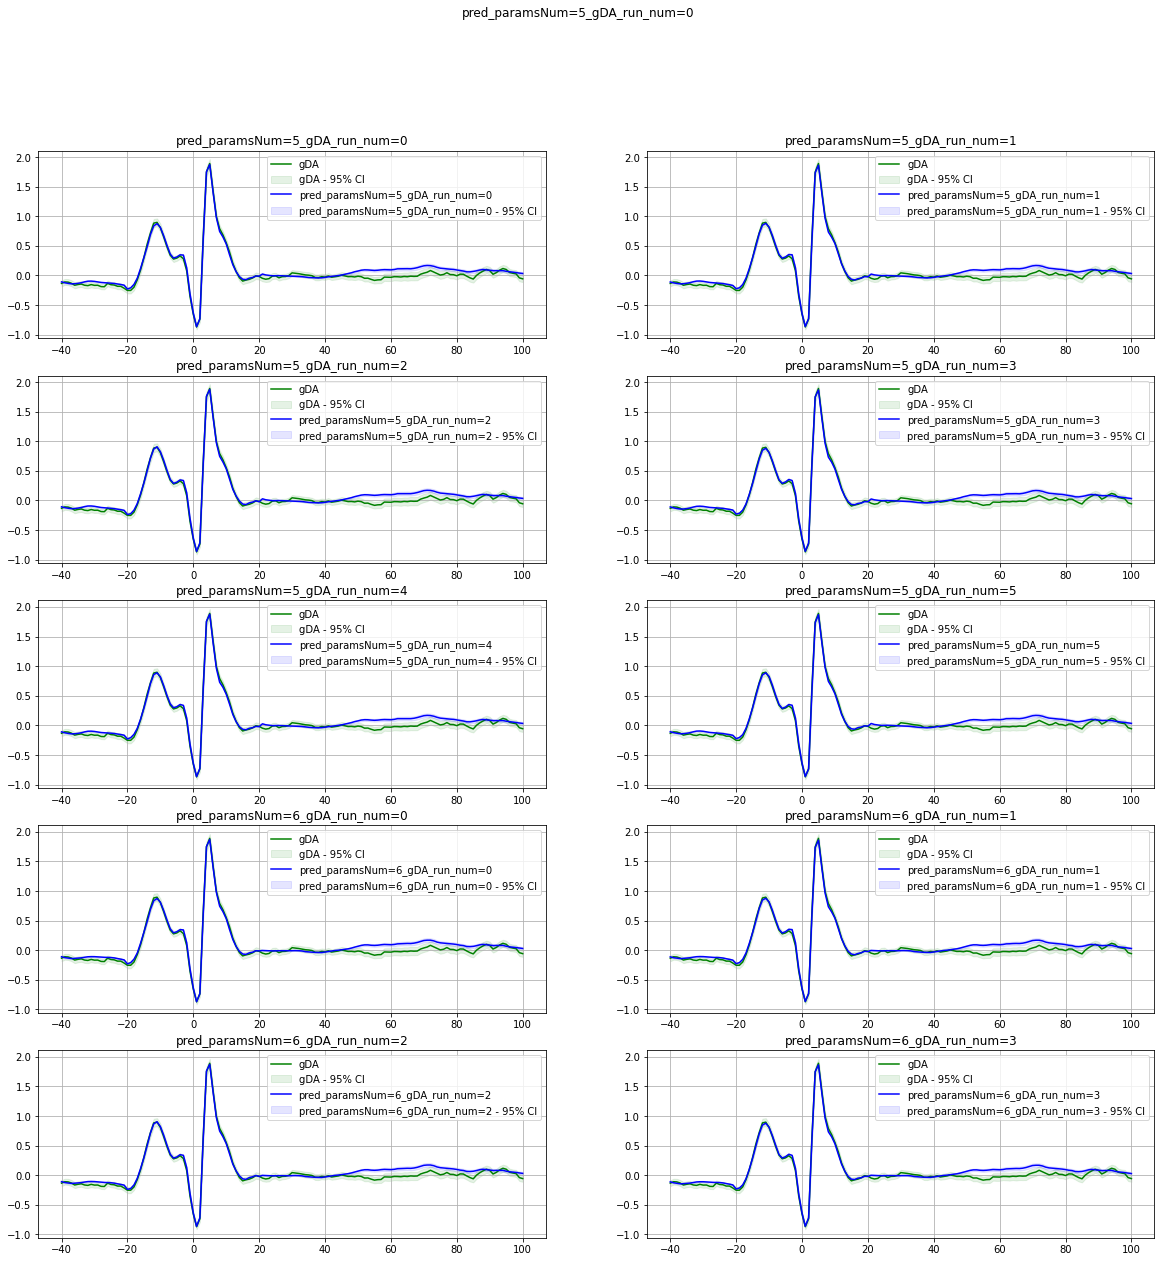

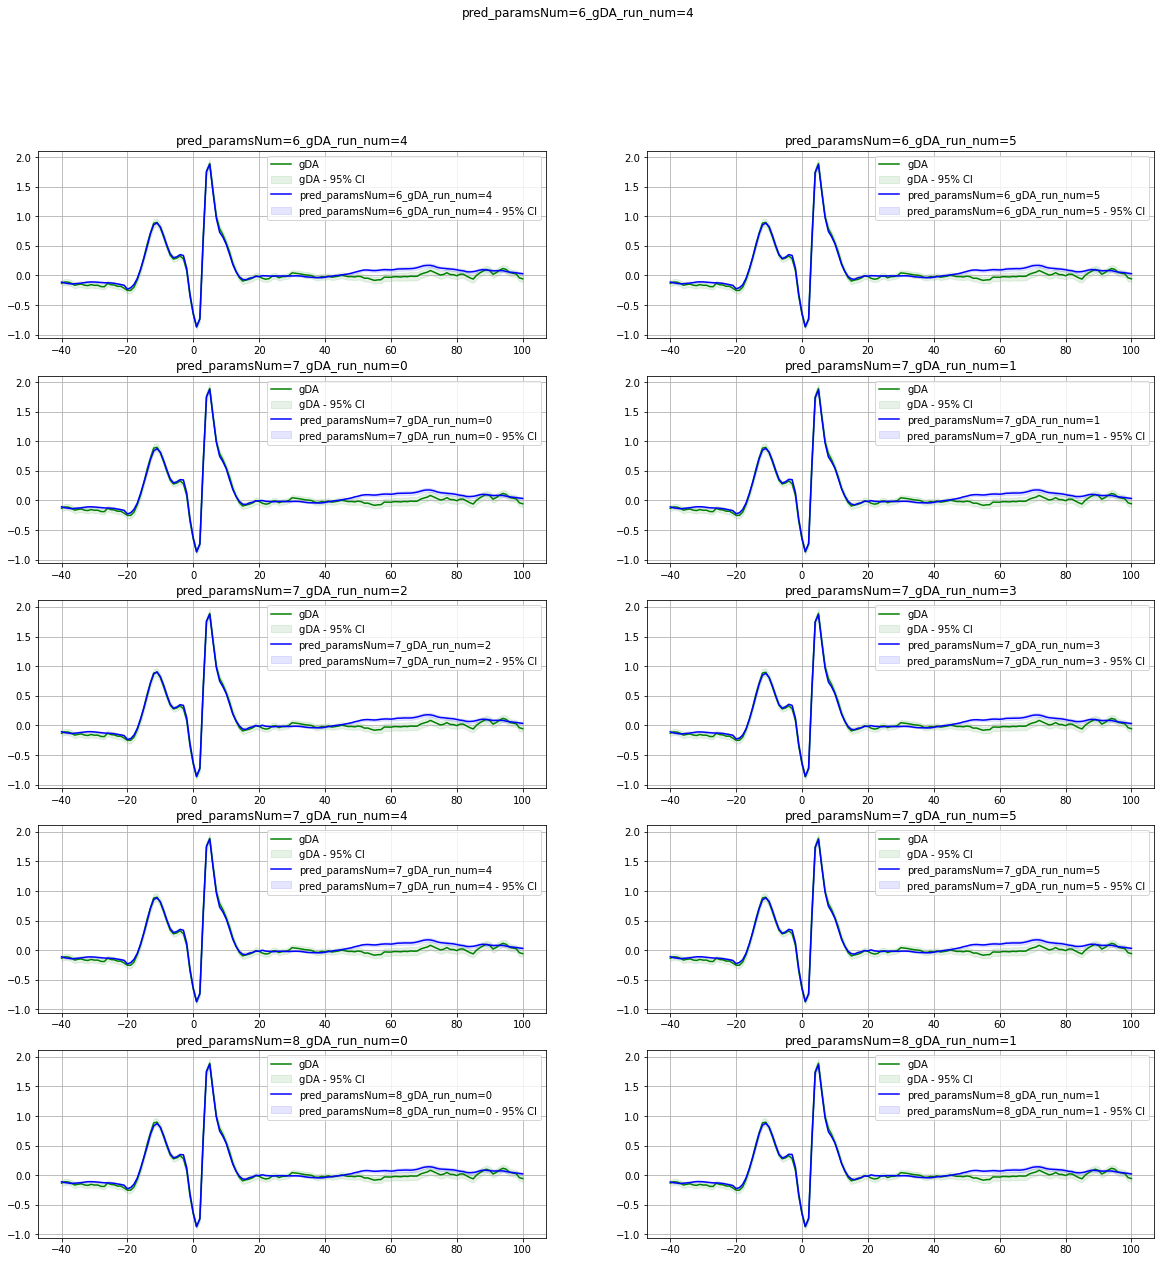

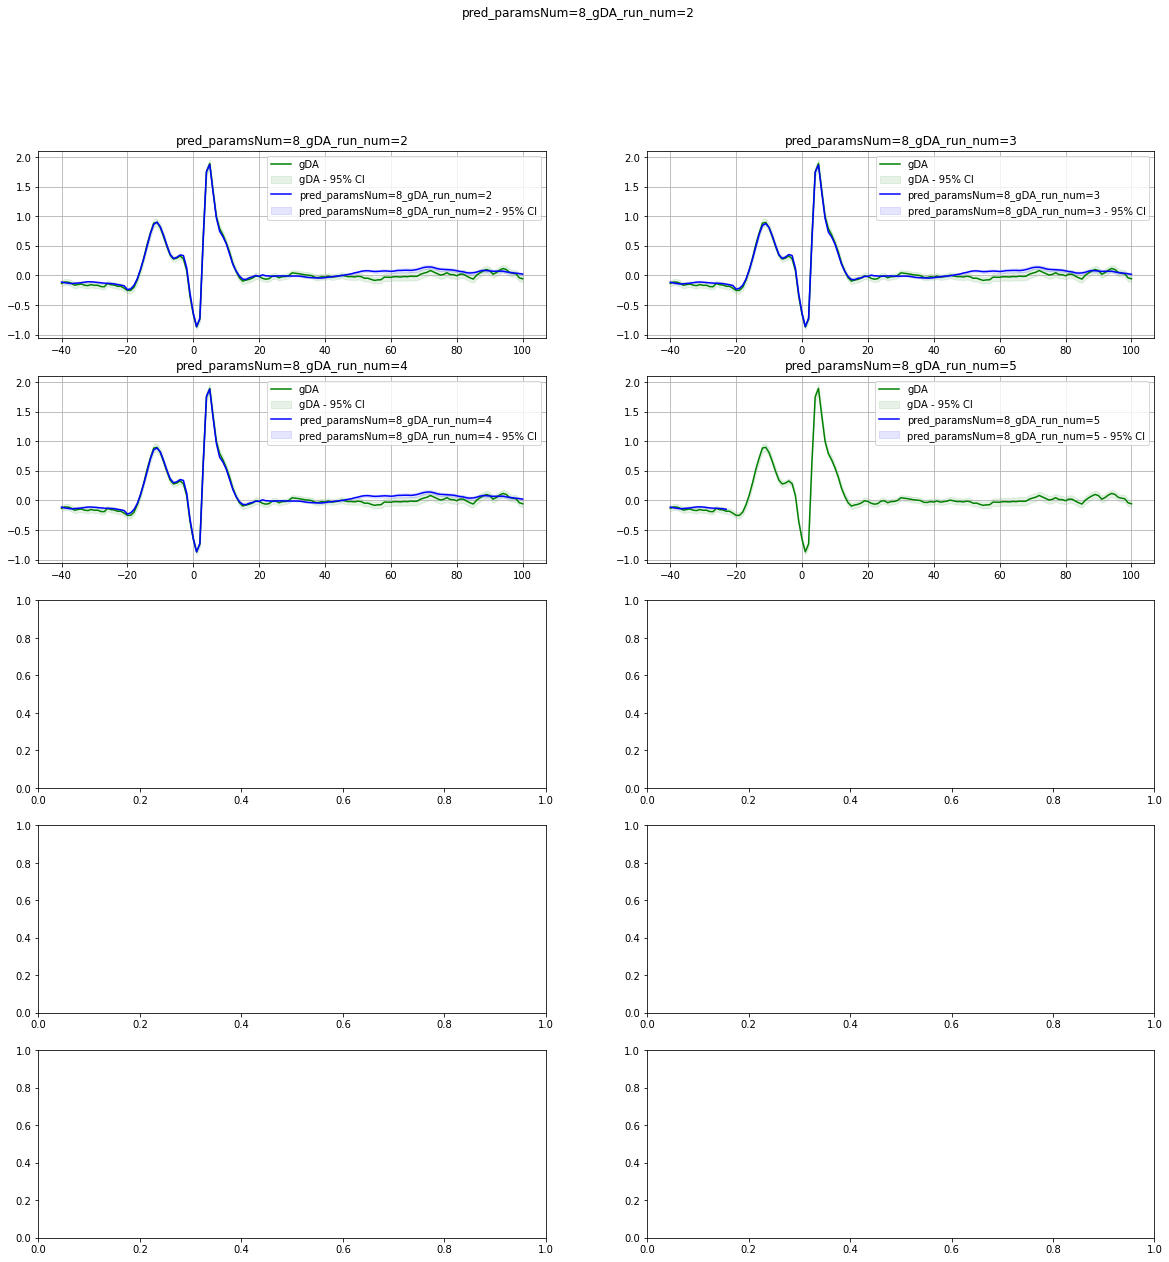

In [51]:
i = 0
for g, gdf in coefs[coefs['col'] != true_col].set_index('delta').groupby(['col']):
    i = i%10
    if i == 0:
        fig,ax_all = plt.subplots(5,2,figsize=(20,20))
        fig.suptitle(g)
    ax = ax_all[i//2, i%2]
    ax.set_title(g)
    true = coefs[coefs['col'] == true_col].set_index('delta')
    ax.plot(true.index, true['mn'], color='g', label=true_col)
    ax.fill_between(true.index, true['lb'], true['ub'], color='g', alpha=.1, label=true_col+' - 95% CI')
    ax.plot(gdf.index, gdf['mn'], color='b', label=g)
    ax.fill_between(gdf.index, gdf['lb'], gdf['ub'], color='b', alpha=.1, label=g+' - 95% CI')
    ax.legend()
    ax.grid()
    i+=1

In [ ]:
# rdc_df.set_index('delta')[true_col]

In [ ]:
# sns.lineplot(x=rdc_df['delta'], y=rdc_df['gDA'], )
# sns.lineplot(x=rdc_df['delta'], y=rdc_df['gACH'], )
# sns.lineplot(x=rdc_df['delta'], y=rdc_df['pred_paramsNum=0_gDA_run_num=0'], )
# sns.lineplot(x=rdc_df['delta'], y=rdc_df['pred_paramsNum=0_gACH_run_num=0'], )


In [ ]:
resid_df['is_holdout'].sum()

In [ ]:
len(ho_inx)

In [ ]:
# lines = ax.lines
# for line in lines:
#     print(line)
#     # print(line.get_xydata())
#     print(line.)
#     # print(len(line.get_data()[0]))
#     # print(len(line.get_data()[1]))


In [ ]:
# rdc_df

In [ ]:
delta_val = []
delta_index = []

for row_num in range(len(tmp_df)):
    # print(row)
    delta = tmp_df.index[row_num]
    row = tmp_df.iloc[row_num].dropna().values
    mn_val = row.mean()
    bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=seed)
    # print(delta, bs, mn_val)

    delta_index.append(delta)
    delta_val.append((bs.confidence_interval.low, mn_val, bs.confidence_interval.high))

delta_bootstrap = pd.DataFrame(delta_val, columns=['lower', 'mean', 'upper'], index=delta_index)

In [ ]:
plt.plot(delta_bootstrap.index, delta_bootstrap['mean'], color='b')
plt.fill_between(delta_bootstrap.index, delta_bootstrap['lower'], delta_bootstrap['upper'], color='b', alpha=.1)

In [ ]:
# tmp_np.shape

In [ ]:
# import scipy
# bs = scipy.stats.bootstrap((tmp_np[0,:],), np.mean, n_resamples=100, batch=None, vectorized=True, paired=False, axis=0, confidence_level=0.95, method='BCa', random_state=seed)
# bs


In [ ]:
# tmp_np.T.shape